In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=2

In [3]:
print FOLD

2


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True,with_l4=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

In [9]:
#show_data(data,columns, 1,480, None)

In [10]:
#show_data2(data,columns)

# cv

In [11]:
n_reg_lookback=28

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [13]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                    ,
                   'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   ,
                    'l3_3000_ridge_fold{}_False_d478.pkl', 'l3_3003_conv_fold{}_False_d478.pkl', 'l3_3006_xgb_fold{}_False_d478.pkl', 'l3_3001_lgb_fold{}_False_d478.pkl'
                   ])

In [15]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [20]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [21]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [24]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testlstm_l4_{}".format(FOLD), n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,model_type='conv',
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [25]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [26]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('l4_3003_conv_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 5803 records out of 5803 records
no valid set
1537
0
26 36 (1, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1537/1537 [==============================] - 25s 16ms/step - loss: 0.2799 - total_loss: 0.2799 - reg_loss: 0.2799 - val_loss: 0.2571 - val_total_loss: 0.2571 - val_reg_loss: 0.2571
Epoch 2/100
1537/1537 [==============================] - 21s 14ms/step - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547 - val_loss:

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.926931  0.002179  0.227168    7  2017-04-16
472     2.507290  2.521144 -0.013853  0.229333    1  2017-04-17
473     2.661330  2.643244  0.018086  0.244834    2  2017-04-18
474     2.754815  2.773774 -0.018959  0.200430    3  2017-04-19
475     2.713762  2.721419 -0.007658  0.228664    4  2017-04-20
476     2.999000  2.991212  0.007788  0.151357    5  2017-04-21
477     3.075529  3.084566 -0.009037  0.185289    6  2017-04-22

0.20958205493
best_epochs [5, 8, 4, 10, 9]
(829, 1) 2.65431496087 

2
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196553, 2) (48450, 2)
train/valid # (196553, 2) (48450, 2)
rand split across time
train has 196553 records out of 372221 records
valid has 48450 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1535
0
26 36 (2, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1535/1535 [==============================] - 26s 17ms/step - loss: 0.2862 - total_loss: 0.2862 - reg_loss: 0.2862 - val_loss: 0.2772 - val_total_loss: 0.2772 - val_reg_loss: 0.2772
Epoch 2/100
1535/1535 [==============================] - 25s 17ms/step 

y      pred     error    error2  day        date
dayidx                                                         
470     2.929110  2.911234  0.017876  0.234700    6  2017-04-15
471     2.507290  2.539221 -0.031930  0.229124    7  2017-04-16
472     2.661330  2.672097 -0.010767  0.250907    1  2017-04-17
473     2.754815  2.732875  0.021940  0.211322    2  2017-04-18
474     2.713762  2.726460 -0.012698  0.237506    3  2017-04-19
475     2.999000  3.010330 -0.011330  0.156104    4  2017-04-20
476     3.075529  3.078945 -0.003416  0.185442    5  2017-04-21

0.215014828688
best_epochs [6, 9, 4, 3, 8]
(829, 1) 2.49977045268 

3
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196376, 2) (48412, 2)
train/valid # (196376, 2) (48412, 2)
rand split across time
train has 196376 records out of 372221 records
valid has 48412 records out of 372221 records
train has 7461 records out of 7461 records
no valid set
1534
0
26 36 (3, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1534/1534 [==============================] - 29s 19ms/step - loss: 0.2869 - total_loss: 0.2869 - reg_loss: 0.2869 - val_loss: 0.2771 - val_total_loss: 0.2771 - val_reg_loss: 0.2771
Epoch 2/100
1534/1534 [==============================] - 24s 15ms/step 

y      pred     error    error2  day        date
dayidx                                                         
469     2.929110  2.880419  0.048691  0.241194    5  2017-04-14
470     2.507290  2.522248 -0.014957  0.233378    6  2017-04-15
471     2.661330  2.653548  0.007782  0.262933    7  2017-04-16
472     2.754815  2.744458  0.010357  0.220788    1  2017-04-17
473     2.713762  2.707039  0.006723  0.241965    2  2017-04-18
474     2.999000  2.975000  0.024000  0.159059    3  2017-04-19
475     3.075529  3.060710  0.014819  0.190396    4  2017-04-20

0.221387483457
best_epochs [6, 3, 7, 5, 4]
(829, 1) 2.63864044744 

4
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196196, 2) (48362, 2)
train/valid # (196196, 2) (48362, 2)
rand split across time
train has 196196 records out of 372221 records
valid has 48362 records out of 372221 records
train has 8290 records out of 8290 records
no valid set
1532
0
26 36 (4, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1532/1532 [==============================] - 29s 19ms/step - loss: 0.2930 - total_loss: 0.2930 - reg_loss: 0.2930 - val_loss: 0.2618 - val_total_loss: 0.2618 - val_reg_loss: 0.2618
Epoch 2/100
1532/1532 [==============================] - 22s 15ms/step 

y      pred     error    error2  day        date
dayidx                                                         
468     2.929110  2.909842  0.019268  0.241838    4  2017-04-13
469     2.507290  2.512902 -0.005612  0.234399    5  2017-04-14
470     2.661330  2.632803  0.028527  0.257180    6  2017-04-15
471     2.754815  2.720380  0.034434  0.219661    7  2017-04-16
472     2.713762  2.710710  0.003052  0.243147    1  2017-04-17
473     2.999000  2.943158  0.055842  0.168854    2  2017-04-18
474     3.075529  3.059940  0.015589  0.183661    3  2017-04-19

0.221248569183
best_epochs [5, 6, 4, 2, 8]
(829, 1) 2.6833139997 

5
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (195980, 2) (48307, 2)
train/valid # (195980, 2) (48307, 2)
rand split across time
train has 195980 records out of 372221 records
valid has 48307 records out of 372221 records
train has 9119 records out of 9119 records
no valid set
1531
0
26 36 (5, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1531/1531 [==============================] - 29s 19ms/step - loss: 0.2913 - total_loss: 0.2913 - reg_loss: 0.2913 - val_loss: 0.2843 - val_total_loss: 0.2843 - val_reg_loss: 0.2843
Epoch 2/100
1531/1531 [==============================] - 28s 18ms/step -

y      pred     error    error2  day        date
dayidx                                                         
467     2.929110  2.900255  0.028855  0.235456    3  2017-04-12
468     2.507290  2.509691 -0.002400  0.237919    4  2017-04-13
469     2.661330  2.611564  0.049766  0.261377    5  2017-04-14
470     2.754815  2.718145  0.036670  0.216375    6  2017-04-15
471     2.713762  2.696123  0.017639  0.246740    7  2017-04-16
472     2.999000  2.982774  0.016226  0.165608    1  2017-04-17
473     3.075529  3.080733 -0.005204  0.185717    2  2017-04-18

0.221313240097
best_epochs [4, 7, 5, 8, 6]
(829, 1) 2.70309936211 

6
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 15.1334
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (195765, 2) (48254, 2)
train/valid # (195765, 2) (48254, 2)
rand split across time
train has 195765 records out of 372221 records
valid has 48254 records out of 372221 records
train has 9948 records out of 9948 records
no valid set
1529
0
26 36 (6, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1529/1529 [==============================] - 29s 19ms/step - loss: 0.2920 - total_loss: 0.2920 - reg_loss: 0.2920 - val_loss: 0.2693 - val_total_loss: 0.2693 - val_reg_loss: 0.2693
Epoch 2/100
1529/1529 [==============================] - 29s 19ms/step 

y      pred     error    error2  day        date
dayidx                                                         
466     2.929110  2.907408  0.021702  0.244679    2  2017-04-11
467     2.507290  2.538902 -0.031612  0.246054    3  2017-04-12
468     2.661330  2.639194  0.022136  0.266181    4  2017-04-13
469     2.754815  2.719823  0.034992  0.216477    5  2017-04-14
470     2.713762  2.714365 -0.000603  0.247296    6  2017-04-15
471     2.999000  2.978393  0.020607  0.163944    7  2017-04-16
472     3.075529  3.091417 -0.015887  0.188017    1  2017-04-17

0.224663901743
best_epochs [3, 8, 7, 5, 4]
(829, 1) 3.0371463024 

7
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 16.3101
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (195541, 2) (48197, 2)
train/valid # (195541, 2) (48197, 2)
rand split across time
train has 195541 records out of 372221 records
valid has 48197 records out of 372221 records
train has 10777 records out of 10777 records
no valid set
1527
0
26 36 (7, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1527/1527 [==============================] - 27s 18ms/step - loss: 0.2939 - total_loss: 0.2939 - reg_loss: 0.2939 - val_loss: 0.2690 - val_total_loss: 0.2690 - val_reg_loss: 0.2690
Epoch 2/100
1527/1527 [==============================] - 29s 19ms/step

y      pred     error    error2  day        date
dayidx                                                         
465     2.929110  2.898434  0.030676  0.248450    1  2017-04-10
466     2.507290  2.525507 -0.018216  0.246079    2  2017-04-11
467     2.661330  2.652245  0.009085  0.268707    3  2017-04-12
468     2.754815  2.732608  0.022206  0.217069    4  2017-04-13
469     2.713762  2.701333  0.012429  0.251695    5  2017-04-14
470     2.999000  2.979969  0.019031  0.161586    6  2017-04-15
471     3.075529  3.073399  0.002130  0.190300    7  2017-04-16

0.226269531555
best_epochs [2, 5, 4, 7, 3]
(829, 1) 2.99364122665 

8
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 17.5743
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (195303, 2) (48140, 2)
train/valid # (195303, 2) (48140, 2)
rand split across time
train has 195303 records out of 372221 records
valid has 48140 records out of 372221 records
train has 11606 records out of 11606 records
no valid set
1525
0
26 36 (8, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1525/1525 [==============================] - 22s 14ms/step - loss: 0.2970 - total_loss: 0.2970 - reg_loss: 0.2970 - val_loss: 0.2710 - val_total_loss: 0.2710 - val_reg_loss: 0.2710
Epoch 2/100
1525/1525 [==============================] - 23s 15ms/ste

y      pred     error    error2  day        date
dayidx                                                         
464     2.929110  2.873481  0.055629  0.256907    7  2017-04-09
465     2.507290  2.515083 -0.007793  0.241904    1  2017-04-10
466     2.661330  2.646549  0.014780  0.271962    2  2017-04-11
467     2.754815  2.725885  0.028930  0.230565    3  2017-04-12
468     2.713762  2.697136  0.016626  0.251398    4  2017-04-13
469     2.999000  2.950128  0.048871  0.172587    5  2017-04-14
470     3.075529  3.087457 -0.011927  0.191790    6  2017-04-15

0.231016025247
best_epochs [6, 3, 2, 4, 7]
(829, 1) 2.73635134021 

9
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 18.8065
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (195075, 2) (48084, 2)
train/valid # (195075, 2) (48084, 2)
rand split across time
train has 195075 records out of 372221 records
valid has 48084 records out of 372221 records
train has 12435 records out of 12435 records
no valid set
1524
0
26 36 (9, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1524/1524 [==============================] - 22s 14ms/step - loss: 0.3034 - total_loss: 0.3034 - reg_loss: 0.3034 - val_loss: 0.2903 - val_total_loss: 0.2903 - val_reg_loss: 0.2903
Epoch 2/100
1524/1524 [==============================] - 23s 15ms/ste

y      pred     error    error2  day        date
dayidx                                                         
463     2.929110  2.912474  0.016636  0.255319    6  2017-04-08
464     2.507290  2.536773 -0.029482  0.243438    7  2017-04-09
465     2.661330  2.661845 -0.000515  0.272975    1  2017-04-10
466     2.754815  2.714579  0.040236  0.232250    2  2017-04-11
467     2.713762  2.725640 -0.011879  0.249181    3  2017-04-12
468     2.999000  2.966836  0.032164  0.168891    4  2017-04-13
469     3.075529  3.099135 -0.023605  0.192749    5  2017-04-14

0.230686271131
best_epochs [5, 4, 3, 2, 6]
(829, 1) 2.57863184649 

10
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 19.9265
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194903, 2) (48047, 2)
train/valid # (194903, 2) (48047, 2)
rand split across time
train has 194903 records out of 372221 records
valid has 48047 records out of 372221 records
train has 13264 records out of 13264 records
no valid set
1522
0
26 36 (10, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1522/1522 [==============================] - 23s 15ms/step - loss: 0.3046 - total_loss: 0.3046 - reg_loss: 0.3046 - val_loss: 0.2741 - val_total_loss: 0.2741 - val_reg_loss: 0.2741
Epoch 2/100
1522/1522 [==============================] - 22s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
462     2.929110  2.893198  0.035912  0.252723    5  2017-04-07
463     2.507290  2.533445 -0.026154  0.240368    6  2017-04-08
464     2.661330  2.670400 -0.009071  0.271188    7  2017-04-09
465     2.754815  2.713488  0.041327  0.229533    1  2017-04-10
466     2.713762  2.710642  0.003120  0.244747    2  2017-04-11
467     2.999000  2.960658  0.038342  0.168534    3  2017-04-12
468     3.075529  3.104556 -0.029027  0.193221    4  2017-04-13

0.228616321563
best_epochs [8, 3, 7, 9, 6]
(829, 1) 2.7112831113 

11
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 21.0577
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194712, 2) (47998, 2)
train/valid # (194712, 2) (47998, 2)
rand split across time
train has 194712 records out of 372221 records
valid has 47998 records out of 372221 records
train has 14093 records out of 14093 records
no valid set
1521
0
26 36 (11, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1521/1521 [==============================] - 26s 17ms/step - loss: 0.3056 - total_loss: 0.3056 - reg_loss: 0.3056 - val_loss: 0.2804 - val_total_loss: 0.2804 - val_reg_loss: 0.2804
Epoch 2/100
1521/1521 [==============================] - 25s 16ms/st

y      pred     error    error2  day        date
dayidx                                                         
461     2.929110  2.888853  0.040257  0.251402    4  2017-04-06
462     2.507290  2.518377 -0.011086  0.245507    5  2017-04-07
463     2.661330  2.639550  0.021779  0.280233    6  2017-04-08
464     2.754815  2.703339  0.051476  0.233698    7  2017-04-09
465     2.713762  2.712914  0.000848  0.250261    1  2017-04-10
466     2.999000  2.966790  0.032210  0.172312    2  2017-04-11
467     3.075529  3.059644  0.015885  0.191689    3  2017-04-12

0.232157430849
best_epochs [4, 5, 3, 2, 7]
(829, 1) 3.01825507049 

12
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 22.1151
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194492, 2) (47945, 2)
train/valid # (194492, 2) (47945, 2)
rand split across time
train has 194492 records out of 372221 records
valid has 47945 records out of 372221 records
train has 14922 records out of 14922 records
no valid set
1519
0
26 36 (12, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1519/1519 [==============================] - 22s 14ms/step - loss: 0.3048 - total_loss: 0.3048 - reg_loss: 0.3048 - val_loss: 0.2759 - val_total_loss: 0.2759 - val_reg_loss: 0.2759
Epoch 2/100
1519/1519 [==============================] - 28s 18ms/s

y      pred     error    error2  day        date
dayidx                                                         
460     2.929110  2.855447  0.073663  0.257334    3  2017-04-05
461     2.507290  2.515589 -0.008299  0.241792    4  2017-04-06
462     2.661330  2.662010 -0.000681  0.275234    5  2017-04-07
463     2.754815  2.725064  0.029751  0.232463    6  2017-04-08
464     2.713762  2.676932  0.036829  0.251594    7  2017-04-09
465     2.999000  2.951230  0.047769  0.174578    1  2017-04-10
466     3.075529  3.062145  0.013384  0.195729    2  2017-04-11

0.232674609414
best_epochs [5, 6, 7, 1, 4]
(829, 1) 2.97942393426 

13
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 23.1552
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194270, 2) (47889, 2)
train/valid # (194270, 2) (47889, 2)
rand split across time
train has 194270 records out of 372221 records
valid has 47889 records out of 372221 records
train has 15751 records out of 15751 records
no valid set
1517
0
26 36 (13, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1517/1517 [==============================] - 25s 17ms/step - loss: 0.3052 - total_loss: 0.3052 - reg_loss: 0.3052 - val_loss: 0.2801 - val_total_loss: 0.2801 - val_reg_loss: 0.2801
Epoch 2/100
1517/1517 [==============================] - 26s 17ms/s

y      pred     error    error2  day        date
dayidx                                                         
459     2.929110  2.889330  0.039780  0.257906    2  2017-04-04
460     2.507290  2.508752 -0.001462  0.245743    3  2017-04-05
461     2.661330  2.650632  0.010697  0.274955    4  2017-04-06
462     2.754815  2.713306  0.041509  0.234100    5  2017-04-07
463     2.713762  2.715883 -0.002121  0.251331    6  2017-04-08
464     2.999000  2.979711  0.019288  0.169380    7  2017-04-09
465     3.075529  3.034103  0.041426  0.191470    1  2017-04-10

0.232126457382
best_epochs [8, 4, 6, 3, 5]
(829, 1) 3.05856089218 

14
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 24.2264
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194056, 2) (47839, 2)
train/valid # (194056, 2) (47839, 2)
rand split across time
train has 194056 records out of 372221 records
valid has 47839 records out of 372221 records
train has 16580 records out of 16580 records
no valid set
1516
0
26 36 (14, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1516/1516 [==============================] - 29s 19ms/step - loss: 0.3043 - total_loss: 0.3043 - reg_loss: 0.3043 - val_loss: 0.2826 - val_total_loss: 0.2826 - val_reg_loss: 0.2826
Epoch 2/100
1516/1516 [==============================] - 28s 19ms/s

y      pred     error    error2  day        date
dayidx                                                         
458     2.929110  2.909404  0.019706  0.258244    1  2017-04-03
459     2.507290  2.553577 -0.046286  0.247869    2  2017-04-04
460     2.661330  2.691951 -0.030621  0.279134    3  2017-04-05
461     2.754815  2.757132 -0.002317  0.234540    4  2017-04-06
462     2.713762  2.726640 -0.012879  0.250085    5  2017-04-07
463     2.999000  2.974067  0.024933  0.167735    6  2017-04-08
464     3.075529  3.070746  0.004783  0.194367    7  2017-04-09

0.233139225721
best_epochs [4, 6, 7, 2, 5]
(829, 1) 3.12243186464 

15
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 25.3577
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193824, 2) (47784, 2)
train/valid # (193824, 2) (47784, 2)
rand split across time
train has 193824 records out of 372221 records
valid has 47784 records out of 372221 records
train has 17409 records out of 17409 records
no valid set
1514
0
26 36 (15, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1514/1514 [==============================] - 28s 19ms/step - loss: 0.3117 - total_loss: 0.3117 - reg_loss: 0.3117 - val_loss: 0.2932 - val_total_loss: 0.2932 - val_reg_loss: 0.2932
Epoch 2/100
1514/1514 [==============================] - 28s 19ms/s

y      pred     error    error2  day        date
dayidx                                                         
457     2.929110  2.937706 -0.008596  0.264625    7  2017-04-02
458     2.507290  2.557129 -0.049838  0.247447    1  2017-04-03
459     2.661330  2.674078 -0.012749  0.282732    2  2017-04-04
460     2.754815  2.718993  0.035822  0.232425    3  2017-04-05
461     2.713762  2.717567 -0.003806  0.253023    4  2017-04-06
462     2.999000  2.992995  0.006005  0.169128    5  2017-04-07
463     3.075529  3.070500  0.005030  0.191798    6  2017-04-08

0.234454146081
best_epochs [5, 6, 8, 3, 9]
(829, 1) 2.7449005515 

16
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 26.4659
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193593, 2) (47725, 2)
train/valid # (193593, 2) (47725, 2)
rand split across time
train has 193593 records out of 372221 records
valid has 47725 records out of 372221 records
train has 18238 records out of 18238 records
no valid set
1512
0
26 36 (16, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1512/1512 [==============================] - 28s 18ms/step - loss: 0.3124 - total_loss: 0.3124 - reg_loss: 0.3124 - val_loss: 0.2888 - val_total_loss: 0.2888 - val_reg_loss: 0.2888
Epoch 2/100
1512/1512 [==============================] - 28s 18ms/st

y      pred     error    error2  day        date
dayidx                                                         
456     2.929110  2.866419  0.062691  0.272743    6  2017-04-01
457     2.507290  2.519057 -0.011766  0.247677    7  2017-04-02
458     2.661330  2.647544  0.013785  0.287235    1  2017-04-03
459     2.754815  2.707957  0.046858  0.238314    2  2017-04-04
460     2.713762  2.708311  0.005451  0.258984    3  2017-04-05
461     2.999000  2.967000  0.032000  0.176616    4  2017-04-06
462     3.075529  3.039841  0.035688  0.196366    5  2017-04-07

0.239704804405
best_epochs [3, 6, 4, 5, 7]
(829, 1) 2.55403740747 

17
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 27.6058
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193415, 2) (47689, 2)
train/valid # (193415, 2) (47689, 2)
rand split across time
train has 193415 records out of 372221 records
valid has 47689 records out of 372221 records
train has 19067 records out of 19067 records
no valid set
1511
0
26 36 (17, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1511/1511 [==============================] - 27s 18ms/step - loss: 0.3171 - total_loss: 0.3171 - reg_loss: 0.3171 - val_loss: 0.2914 - val_total_loss: 0.2914 - val_reg_loss: 0.2914
Epoch 2/100
1511/1511 [==============================] - 28s 18ms/s

y      pred     error    error2  day        date
dayidx                                                         
455     2.929110  2.880723  0.048387  0.272255    5  2017-03-31
456     2.507290  2.491128  0.016163  0.249487    6  2017-04-01
457     2.661330  2.638276  0.023053  0.283049    7  2017-04-02
458     2.754815  2.705288  0.049527  0.246656    1  2017-04-03
459     2.713762  2.710216  0.003546  0.255118    2  2017-04-04
460     2.999000  2.968504  0.030496  0.179642    3  2017-04-05
461     3.075529  3.029626  0.045903  0.198701    4  2017-04-06

0.240701090093
best_epochs [5, 2, 4, 6, 3]
(829, 1) 2.63105926525 

18
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 28.7513
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193227, 2) (47641, 2)
train/valid # (193227, 2) (47641, 2)
rand split across time
train has 193227 records out of 372221 records
valid has 47641 records out of 372221 records
train has 19896 records out of 19896 records
no valid set
1509
0
26 36 (18, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1509/1509 [==============================] - 25s 17ms/step - loss: 0.3125 - total_loss: 0.3125 - reg_loss: 0.3125 - val_loss: 0.2891 - val_total_loss: 0.2891 - val_reg_loss: 0.2891
Epoch 2/100
1509/1509 [==============================] - 27s 18ms/s

y      pred     error    error2  day        date
dayidx                                                         
454     2.929110  2.885153  0.043957  0.270056    4  2017-03-30
455     2.507290  2.508245 -0.000955  0.251547    5  2017-03-31
456     2.661330  2.641676  0.019654  0.281511    6  2017-04-01
457     2.754815  2.710553  0.044262  0.235668    7  2017-04-02
458     2.713762  2.694877  0.018884  0.260870    1  2017-04-03
459     2.999000  2.974276  0.024723  0.175264    2  2017-04-04
460     3.075529  3.043648  0.031881  0.197538    3  2017-04-05

0.238921878538
best_epochs [5, 7, 6, 2, 9]
(829, 1) 2.76304088257 

19
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 29.7986
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193012, 2) (47591, 2)
train/valid # (193012, 2) (47591, 2)
rand split across time
train has 193012 records out of 372221 records
valid has 47591 records out of 372221 records
train has 20725 records out of 20725 records
no valid set
1507
0
26 36 (19, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1507/1507 [==============================] - 28s 19ms/step - loss: 0.3152 - total_loss: 0.3152 - reg_loss: 0.3152 - val_loss: 0.2890 - val_total_loss: 0.2890 - val_reg_loss: 0.2890
Epoch 2/100
1507/1507 [==============================] - 28s 18ms/s

y      pred     error    error2  day        date
dayidx                                                         
453     2.929110  2.910664  0.018446  0.277866    3  2017-03-29
454     2.507290  2.526233 -0.018943  0.256562    4  2017-03-30
455     2.661330  2.634973  0.026357  0.291198    5  2017-03-31
456     2.754815  2.687550  0.067264  0.245301    6  2017-04-01
457     2.713762  2.693011  0.020751  0.265590    7  2017-04-02
458     2.999000  2.966627  0.032373  0.183776    1  2017-04-03
459     3.075529  3.041148  0.034381  0.203009    2  2017-04-04

0.246185990893
best_epochs [3, 2, 6, 5, 4]
(829, 1) 2.71946410517 

20
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 30.7963
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192796, 2) (47540, 2)
train/valid # (192796, 2) (47540, 2)
rand split across time
train has 192796 records out of 372221 records
valid has 47540 records out of 372221 records
train has 21554 records out of 21554 records
no valid set
1506
0
26 36 (20, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1506/1506 [==============================] - 28s 19ms/step - loss: 0.3149 - total_loss: 0.3149 - reg_loss: 0.3149 - val_loss: 0.2879 - val_total_loss: 0.2879 - val_reg_loss: 0.2879
Epoch 2/100
1506/1506 [==============================] - 28s 19ms/s

y      pred     error    error2  day        date
dayidx                                                         
452     2.929110  2.892077  0.037033  0.271753    2  2017-03-28
453     2.507290  2.550786 -0.043495  0.254283    3  2017-03-29
454     2.661330  2.635396  0.025934  0.287554    4  2017-03-30
455     2.754815  2.728950  0.025864  0.240378    5  2017-03-31
456     2.713762  2.708968  0.004794  0.270657    6  2017-04-01
457     2.999000  2.957650  0.041349  0.179527    7  2017-04-02
458     3.075529  3.016682  0.058848  0.202590    1  2017-04-03

0.243820533506
best_epochs [5, 3, 4, 2, 6]
(829, 1) 2.94813765111 

21
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 31.7929
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192578, 2) (47490, 2)
train/valid # (192578, 2) (47490, 2)
rand split across time
train has 192578 records out of 372221 records
valid has 47490 records out of 372221 records
train has 22383 records out of 22383 records
no valid set
1504
0
26 36 (21, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1504/1504 [==============================] - 28s 19ms/step - loss: 0.3215 - total_loss: 0.3215 - reg_loss: 0.3215 - val_loss: 0.3016 - val_total_loss: 0.3016 - val_reg_loss: 0.3016
Epoch 2/100
1504/1504 [==============================] - 28s 19ms/s

y      pred     error    error2  day        date
dayidx                                                         
451     2.929110  2.860265  0.068845  0.281123    1  2017-03-27
452     2.507290  2.534930 -0.027640  0.249791    2  2017-03-28
453     2.661330  2.673794 -0.012464  0.283506    3  2017-03-29
454     2.754815  2.736058  0.018757  0.237989    4  2017-03-30
455     2.713762  2.697824  0.015938  0.265648    5  2017-03-31
456     2.999000  2.938408  0.060592  0.185243    6  2017-04-01
457     3.075529  3.040444  0.035086  0.198689    7  2017-04-02

0.24314119433
best_epochs [6, 4, 7, 8, 3]
(829, 1) 3.03673331522 

22
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 32.871
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192344, 2) (47435, 2)
train/valid # (192344, 2) (47435, 2)
rand split across time
train has 192344 records out of 372221 records
valid has 47435 records out of 372221 records
train has 23212 records out of 23212 records
no valid set
1502
0
26 36 (22, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1502/1502 [==============================] - 28s 19ms/step - loss: 0.3181 - total_loss: 0.3181 - reg_loss: 0.3181 - val_loss: 0.2975 - val_total_loss: 0.2975 - val_reg_loss: 0.2975
Epoch 2/100
1502/1502 [==============================] - 28s 19ms/ste

y      pred     error    error2  day        date
dayidx                                                         
450     2.929110  2.890502  0.038608  0.274682    7  2017-03-26
451     2.507290  2.493520  0.013770  0.257571    1  2017-03-27
452     2.661330  2.639462  0.021868  0.286134    2  2017-03-28
453     2.754815  2.717989  0.036826  0.244908    3  2017-03-29
454     2.713762  2.674406  0.039356  0.273758    4  2017-03-30
455     2.999000  2.952752  0.046248  0.186661    5  2017-03-31
456     3.075529  3.045970  0.029559  0.203397    6  2017-04-01

0.24673021844
best_epochs [5, 4, 3, 6, 7]
(829, 1) 2.68032406325 

23
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 33.9745
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192110, 2) (47379, 2)
train/valid # (192110, 2) (47379, 2)
rand split across time
train has 192110 records out of 372221 records
valid has 47379 records out of 372221 records
train has 24041 records out of 24041 records
no valid set
1500
0
26 36 (23, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1500/1500 [==============================] - 28s 19ms/step - loss: 0.3197 - total_loss: 0.3197 - reg_loss: 0.3197 - val_loss: 0.2973 - val_total_loss: 0.2973 - val_reg_loss: 0.2973
Epoch 2/100
1500/1500 [==============================] - 27s 18ms/st

y      pred     error    error2  day        date
dayidx                                                         
449     2.929110  2.892258  0.036852  0.272169    6  2017-03-25
450     2.507290  2.500222  0.007068  0.255953    7  2017-03-26
451     2.661330  2.637169  0.024160  0.281817    1  2017-03-27
452     2.754815  2.690931  0.063884  0.245112    2  2017-03-28
453     2.713762  2.668589  0.045172  0.269681    3  2017-03-29
454     2.999000  2.942989  0.056011  0.189717    4  2017-03-30
455     3.075529  3.031757  0.043773  0.199767    5  2017-03-31

0.244888054428
best_epochs [6, 2, 4, 5, 8]
(829, 1) 2.46044522758 

24
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 35.2084
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191932, 2) (47343, 2)
train/valid # (191932, 2) (47343, 2)
rand split across time
train has 191932 records out of 372221 records
valid has 47343 records out of 372221 records
train has 24870 records out of 24870 records
no valid set
1499
0
26 36 (24, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1499/1499 [==============================] - 27s 18ms/step - loss: 0.3219 - total_loss: 0.3219 - reg_loss: 0.3219 - val_loss: 0.2961 - val_total_loss: 0.2961 - val_reg_loss: 0.2961
Epoch 2/100
1499/1499 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
448     2.929110  2.915084  0.014025  0.274084    5  2017-03-24
449     2.507290  2.489598  0.017693  0.257569    6  2017-03-25
450     2.661330  2.625774  0.035556  0.286811    7  2017-03-26
451     2.754815  2.695244  0.059571  0.247028    1  2017-03-27
452     2.713762  2.688996  0.024766  0.272493    2  2017-03-28
453     2.999000  2.958609  0.040391  0.186888    3  2017-03-29
454     3.075529  3.039785  0.035744  0.202120    4  2017-03-30

0.24671323663
best_epochs [6, 1, 7, 3, 4]
(829, 1) 2.5630916782 

25
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 36.3351
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191750, 2) (47298, 2)
train/valid # (191750, 2) (47298, 2)
rand split across time
train has 191750 records out of 372221 records
valid has 47298 records out of 372221 records
train has 25699 records out of 25699 records
no valid set
1498
0
26 36 (25, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1498/1498 [==============================] - 22s 15ms/step - loss: 0.3201 - total_loss: 0.3201 - reg_loss: 0.3201 - val_loss: 0.3014 - val_total_loss: 0.3014 - val_reg_loss: 0.3014
Epoch 2/100
1498/1498 [==============================] - 22s 14ms/ste

y      pred     error    error2  day        date
dayidx                                                         
447     2.929110  2.924435  0.004675  0.274074    4  2017-03-23
448     2.507290  2.504349  0.002942  0.257069    5  2017-03-24
449     2.661330  2.644792  0.016538  0.287666    6  2017-03-25
450     2.754815  2.734092  0.020722  0.245188    7  2017-03-26
451     2.713762  2.704059  0.009703  0.271623    1  2017-03-27
452     2.999000  2.985628  0.013372  0.183006    2  2017-03-28
453     3.075529  3.069367  0.006162  0.203962    3  2017-03-29

0.246083988891
best_epochs [4, 6, 7, 3, 5]
(829, 1) 2.71517727982 

26
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 37.3741
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191537, 2) (47247, 2)
train/valid # (191537, 2) (47247, 2)
rand split across time
train has 191537 records out of 372221 records
valid has 47247 records out of 372221 records
train has 26528 records out of 26528 records
no valid set
1496
0
26 36 (26, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1496/1496 [==============================] - 24s 16ms/step - loss: 0.3230 - total_loss: 0.3230 - reg_loss: 0.3230 - val_loss: 0.2997 - val_total_loss: 0.2997 - val_reg_loss: 0.2997
Epoch 2/100
1496/1496 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
446     2.929110  2.877049  0.052061  0.278801    3  2017-03-22
447     2.507290  2.496347  0.010943  0.253294    4  2017-03-23
448     2.661330  2.638842  0.022487  0.287167    5  2017-03-24
449     2.754815  2.721992  0.032822  0.243484    6  2017-03-25
450     2.713762  2.671001  0.042761  0.275917    7  2017-03-26
451     2.999000  2.963754  0.035246  0.185791    1  2017-03-27
452     3.075529  3.045457  0.030072  0.204553    2  2017-03-28

0.247000850974
best_epochs [4, 5, 6, 8, 7]
(829, 1) 2.68688462108 

27
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 38.4506
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191318, 2) (47193, 2)
train/valid # (191318, 2) (47193, 2)
rand split across time
train has 191318 records out of 372221 records
valid has 47193 records out of 372221 records
train has 27357 records out of 27357 records
no valid set
1494
0
26 36 (27, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1494/1494 [==============================] - 25s 16ms/step - loss: 0.3231 - total_loss: 0.3231 - reg_loss: 0.3231 - val_loss: 0.3146 - val_total_loss: 0.3146 - val_reg_loss: 0.3146
Epoch 2/100
1494/1494 [==============================] - 22s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
445     2.929110  2.895429  0.033681  0.278693    2  2017-03-21
446     2.507290  2.543894 -0.036604  0.261105    3  2017-03-22
447     2.661330  2.686111 -0.024781  0.286842    4  2017-03-23
448     2.754815  2.742156  0.012659  0.244463    5  2017-03-24
449     2.713762  2.701112  0.012649  0.269087    6  2017-03-25
450     2.999000  2.963241  0.035759  0.190485    7  2017-03-26
451     3.075529  3.037079  0.038450  0.201772    1  2017-03-27

0.247492409617
best_epochs [3, 6, 5, 2, 8]
(829, 1) 3.03098833884 

28
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 39.4798
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191090, 2) (47141, 2)
train/valid # (191090, 2) (47141, 2)
rand split across time
train has 191090 records out of 372221 records
valid has 47141 records out of 372221 records
train has 28186 records out of 28186 records
no valid set
1492
0
26 36 (28, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1492/1492 [==============================] - 25s 17ms/step - loss: 0.3218 - total_loss: 0.3218 - reg_loss: 0.3218 - val_loss: 0.3014 - val_total_loss: 0.3014 - val_reg_loss: 0.3014
Epoch 2/100
1492/1492 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
444     2.929110  2.918893  0.010217  0.283994    1  2017-03-20
445     2.507290  2.531675 -0.024384  0.265245    2  2017-03-21
446     2.661330  2.650184  0.011146  0.285078    3  2017-03-22
447     2.754815  2.717809  0.037006  0.252222    4  2017-03-23
448     2.713762  2.690135  0.023626  0.275881    5  2017-03-24
449     2.999000  2.969213  0.029787  0.188564    6  2017-03-25
450     3.075529  3.035141  0.040388  0.206876    7  2017-03-26

0.251123067211
best_epochs [5, 3, 4, 2, 6]
(829, 1) 3.08737883903 

29
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 40.7934
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190851, 2) (47085, 2)
train/valid # (190851, 2) (47085, 2)
rand split across time
train has 190851 records out of 372221 records
valid has 47085 records out of 372221 records
train has 29015 records out of 29015 records
no valid set
1491
0
26 36 (29, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1491/1491 [==============================] - 23s 16ms/step - loss: 0.3268 - total_loss: 0.3268 - reg_loss: 0.3268 - val_loss: 0.3007 - val_total_loss: 0.3007 - val_reg_loss: 0.3007
Epoch 2/100
1491/1491 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
443     2.929110  2.890512  0.038598  0.273336    7  2017-03-19
444     2.507290  2.516285 -0.008994  0.256533    1  2017-03-20
445     2.661330  2.658965  0.002365  0.289174    2  2017-03-21
446     2.754815  2.711864  0.042951  0.248419    3  2017-03-22
447     2.713762  2.698994  0.014767  0.265950    4  2017-03-23
448     2.999000  2.976410  0.022590  0.185768    5  2017-03-24
449     3.075529  3.042050  0.033480  0.211536    6  2017-03-25

0.247245082147
best_epochs [4, 5, 7, 3, 6]
(829, 1) 2.7532648872 

30
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 41.9859
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190615, 2) (47030, 2)
train/valid # (190615, 2) (47030, 2)
rand split across time
train has 190615 records out of 372221 records
valid has 47030 records out of 372221 records
train has 29844 records out of 29844 records
no valid set
1489
0
26 36 (30, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1488/1489 [============================>.] - ETA: 0s - loss: 8.5597 - total_loss: 8.5597 - reg_loss: 8.5597Epoch 00001: saving model to testlstm_l4_2/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1489/1489 [==========================

y      pred     error    error2  day        date
dayidx                                                         
442     2.929110  2.919090  0.010020  0.278760    6  2017-03-18
443     2.507290  2.535974 -0.028684  0.253725    7  2017-03-19
444     2.661330  2.625252  0.036078  0.297599    1  2017-03-20
445     2.754815  2.712022  0.042793  0.252407    2  2017-03-21
446     2.713762  2.695183  0.018579  0.264754    3  2017-03-22
447     2.999000  2.988298  0.010702  0.188825    4  2017-03-23
448     3.075529  3.077586 -0.002057  0.205607    5  2017-03-24

0.248811021007
best_epochs [1, 6, 4, 5, 3]
(829, 1) 2.5882436555 

31
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 43.2281
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190426, 2) (46991, 2)
train/valid # (190426, 2) (46991, 2)
rand split across time
train has 190426 records out of 372221 records
valid has 46991 records out of 372221 records
train has 30673 records out of 30673 records
no valid set
1487
0
26 36 (31, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1487/1487 [==============================] - 28s 19ms/step - loss: 0.3277 - total_loss: 0.3277 - reg_loss: 0.3277 - val_loss: 0.3061 - val_total_loss: 0.3061 - val_reg_loss: 0.3061
Epoch 2/100
1487/1487 [==============================] - 23s 15ms/st

y      pred     error    error2  day        date
dayidx                                                         
441     2.929110  2.902114  0.026996  0.278819    5  2017-03-17
442     2.507290  2.525885 -0.018595  0.257095    6  2017-03-18
443     2.661330  2.637539  0.023791  0.302596    7  2017-03-19
444     2.754815  2.720737  0.034078  0.252397    1  2017-03-20
445     2.713762  2.669834  0.043928  0.273369    2  2017-03-21
446     2.999000  2.962828  0.036171  0.187426    3  2017-03-22
447     3.075529  3.021305  0.054225  0.208050    4  2017-03-23

0.251393069271
best_epochs [6, 4, 2, 7, 5]
(829, 1) 2.71008267648 

32
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 44.4464
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190239, 2) (46945, 2)
train/valid # (190239, 2) (46945, 2)
rand split across time
train has 190239 records out of 372221 records
valid has 46945 records out of 372221 records
train has 31502 records out of 31502 records
no valid set
1486
0
26 36 (32, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1486/1486 [==============================] - 27s 18ms/step - loss: 0.3277 - total_loss: 0.3277 - reg_loss: 0.3277 - val_loss: 0.3058 - val_total_loss: 0.3058 - val_reg_loss: 0.3058
Epoch 2/100
1486/1486 [==============================] - 22s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
440     2.929110  2.866667  0.062442  0.278572    4  2017-03-16
441     2.507290  2.500693  0.006598  0.254621    5  2017-03-17
442     2.661330  2.626692  0.034637  0.294532    6  2017-03-18
443     2.754815  2.707759  0.047056  0.257381    7  2017-03-19
444     2.713762  2.703145  0.010616  0.270372    1  2017-03-20
445     2.999000  2.950106  0.048894  0.193719    2  2017-03-21
446     3.075529  3.056648  0.018881  0.208488    3  2017-03-22

0.251097749366
best_epochs [4, 3, 5, 2, 1]
(829, 1) 2.75156833486 

33
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 45.5115
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190025, 2) (46892, 2)
train/valid # (190025, 2) (46892, 2)
rand split across time
train has 190025 records out of 372221 records
valid has 46892 records out of 372221 records
train has 32331 records out of 32331 records
no valid set
1484
0
26 36 (33, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1484/1484 [==============================] - 26s 18ms/step - loss: 0.3471 - total_loss: 0.3471 - reg_loss: 0.3471 - val_loss: 0.3031 - val_total_loss: 0.3031 - val_reg_loss: 0.3031
Epoch 2/100
1484/1484 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
439     2.929110  2.923114  0.005996  0.280689    3  2017-03-15
440     2.507290  2.554851 -0.047561  0.257412    4  2017-03-16
441     2.661330  2.660432  0.000898  0.290040    5  2017-03-17
442     2.754815  2.733961  0.020853  0.249410    6  2017-03-18
443     2.713762  2.707047  0.006714  0.262852    7  2017-03-19
444     2.999000  2.940677  0.058323  0.193037    1  2017-03-20
445     3.075529  3.078390 -0.002861  0.211097    2  2017-03-21

0.249219430618
best_epochs [4, 3, 5, 1, 6]
(829, 1) 2.76073130524 

34
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 46.5688
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189797, 2) (46844, 2)
train/valid # (189797, 2) (46844, 2)
rand split across time
train has 189797 records out of 372221 records
valid has 46844 records out of 372221 records
train has 33160 records out of 33160 records
no valid set
1482
0
26 36 (34, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1482/1482 [==============================] - 28s 19ms/step - loss: 0.3285 - total_loss: 0.3285 - reg_loss: 0.3285 - val_loss: 0.3057 - val_total_loss: 0.3057 - val_reg_loss: 0.3057
Epoch 2/100
1482/1482 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
438     2.929110  2.910298  0.018812  0.274368    2  2017-03-14
439     2.507290  2.541896 -0.034606  0.258529    3  2017-03-15
440     2.661330  2.673896 -0.012566  0.294357    4  2017-03-16
441     2.754815  2.745331  0.009484  0.251049    5  2017-03-17
442     2.713762  2.715173 -0.001411  0.264593    6  2017-03-18
443     2.999000  2.970651  0.028349  0.188084    7  2017-03-19
444     3.075529  3.067458  0.008071  0.209349    1  2017-03-20

0.248618476078
best_epochs [3, 6, 5, 1, 2]
(829, 1) 3.01757139522 

35
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 47.4733
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189571, 2) (46792, 2)
train/valid # (189571, 2) (46792, 2)
rand split across time
train has 189571 records out of 372221 records
valid has 46792 records out of 372221 records
train has 33989 records out of 33989 records
no valid set
1481
0
26 36 (35, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1481/1481 [==============================] - 28s 19ms/step - loss: 0.3308 - total_loss: 0.3308 - reg_loss: 0.3308 - val_loss: 0.3165 - val_total_loss: 0.3165 - val_reg_loss: 0.3165
Epoch 2/100
1481/1481 [==============================] - 27s 19ms/s

y      pred     error    error2  day        date
dayidx                                                         
437     2.929110  2.892974  0.036136  0.276054    1  2017-03-13
438     2.507290  2.560226 -0.052936  0.260964    2  2017-03-14
439     2.661330  2.643395  0.017935  0.292242    3  2017-03-15
440     2.754815  2.759003 -0.004188  0.252103    4  2017-03-16
441     2.713762  2.700896  0.012865  0.264530    5  2017-03-17
442     2.999000  2.945256  0.053743  0.188491    6  2017-03-18
443     3.075529  3.060360  0.015169  0.205870    7  2017-03-19

0.248607777455
best_epochs [4, 5, 2, 3, 6]
(829, 1) 3.12809456051 

36
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 48.7491
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189331, 2) (46737, 2)
train/valid # (189331, 2) (46737, 2)
rand split across time
train has 189331 records out of 372221 records
valid has 46737 records out of 372221 records
train has 34818 records out of 34818 records
no valid set
1479
0
26 36 (36, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1479/1479 [==============================] - 28s 19ms/step - loss: 0.3349 - total_loss: 0.3349 - reg_loss: 0.3349 - val_loss: 0.3076 - val_total_loss: 0.3076 - val_reg_loss: 0.3076
Epoch 2/100
1479/1479 [==============================] - 27s 18ms/s

y      pred     error    error2  day        date
dayidx                                                         
436     2.929110  2.881938  0.047172  0.292997    7  2017-03-12
437     2.507290  2.500498  0.006793  0.257186    1  2017-03-13
438     2.661330  2.643814  0.017516  0.289707    2  2017-03-14
439     2.754815  2.711764  0.043051  0.259422    3  2017-03-15
440     2.713762  2.698628  0.015133  0.275411    4  2017-03-16
441     2.999000  2.936991  0.062009  0.193764    5  2017-03-17
442     3.075529  3.056896  0.018633  0.214743    6  2017-03-18

0.254747230075
best_epochs [3, 1, 6, 5, 2]
(829, 1) 2.77444295772 

37
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 49.8797
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189098, 2) (46683, 2)
train/valid # (189098, 2) (46683, 2)
rand split across time
train has 189098 records out of 372221 records
valid has 46683 records out of 372221 records
train has 35647 records out of 35647 records
no valid set
1477
0
26 36 (37, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1477/1477 [==============================] - 28s 19ms/step - loss: 0.3327 - total_loss: 0.3327 - reg_loss: 0.3327 - val_loss: 0.3092 - val_total_loss: 0.3092 - val_reg_loss: 0.3092
Epoch 2/100
1477/1477 [==============================] - 27s 18ms/s

y      pred     error    error2  day        date
dayidx                                                         
435     2.929110  2.889085  0.040025  0.288068    6  2017-03-11
436     2.507290  2.503601  0.003690  0.259186    7  2017-03-12
437     2.661330  2.635766  0.025564  0.291761    1  2017-03-13
438     2.754815  2.714973  0.039842  0.261917    2  2017-03-14
439     2.713762  2.707950  0.005811  0.272261    3  2017-03-15
440     2.999000  2.932297  0.066702  0.195715    4  2017-03-16
441     3.075529  3.054185  0.021344  0.218340    5  2017-03-17

0.255321154819
best_epochs [4, 6, 5, 2, 1]
(829, 1) 2.57606687231 

38
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 51.0865
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188915, 2) (46647, 2)
train/valid # (188915, 2) (46647, 2)
rand split across time
train has 188915 records out of 372221 records
valid has 46647 records out of 372221 records
train has 36476 records out of 36476 records
no valid set
1475
0
26 36 (38, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1475/1475 [==============================] - 28s 19ms/step - loss: 0.3376 - total_loss: 0.3376 - reg_loss: 0.3376 - val_loss: 0.3137 - val_total_loss: 0.3137 - val_reg_loss: 0.3137
Epoch 2/100
1475/1475 [==============================] - 27s 18ms/s

y      pred     error    error2  day        date
dayidx                                                         
434     2.929110  2.897137  0.031972  0.292825    5  2017-03-10
435     2.507290  2.516455 -0.009165  0.261490    6  2017-03-11
436     2.661330  2.663691 -0.002361  0.295453    7  2017-03-12
437     2.754815  2.704701  0.050114  0.258528    1  2017-03-13
438     2.713762  2.678453  0.035309  0.277289    2  2017-03-14
439     2.999000  2.963417  0.035583  0.191339    3  2017-03-15
440     3.075529  3.064780  0.010749  0.212204    4  2017-03-16

0.255589876343
best_epochs [5, 4, 3, 6, 2]
(829, 1) 2.70821680298 

39
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 52.0488
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188729, 2) (46602, 2)
train/valid # (188729, 2) (46602, 2)
rand split across time
train has 188729 records out of 372221 records
valid has 46602 records out of 372221 records
train has 37305 records out of 37305 records
no valid set
1474
0
26 36 (39, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1474/1474 [==============================] - 21s 14ms/step - loss: 0.3376 - total_loss: 0.3376 - reg_loss: 0.3376 - val_loss: 0.3158 - val_total_loss: 0.3158 - val_reg_loss: 0.3158
Epoch 2/100
1474/1474 [==============================] - 20s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
433     2.929110  2.913077  0.016033  0.287948    4  2017-03-09
434     2.507290  2.515811 -0.008520  0.257339    5  2017-03-10
435     2.661330  2.644999  0.016330  0.284650    6  2017-03-11
436     2.754815  2.714868  0.039947  0.257950    7  2017-03-12
437     2.713762  2.676815  0.036947  0.276064    1  2017-03-13
438     2.999000  2.927616  0.071384  0.194162    2  2017-03-14
439     3.075529  3.028545  0.046985  0.213730    3  2017-03-15

0.253120415884
best_epochs [4, 5, 7, 3, 2]
(829, 1) 2.76283612041


In [27]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

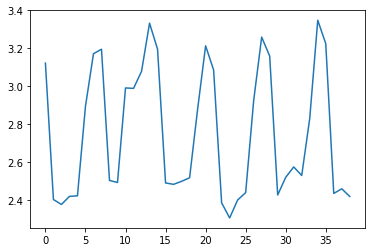

In [28]:
plt.plot(testpreds[129])

In [29]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [30]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.783377   
air_0164b9927d20bcc3_2017-04-23              1.411483   
air_0241aa3964b7f861_2017-04-23              2.390822   
air_0328696196e46f18_2017-04-23              2.150793   
air_034a3d5b40d5b1b1_2017-04-23              3.537208   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   4.949913  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.102036  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.922463  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.591666  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  33.370830

In [31]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [32]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [33]:
submission.to_csv("../submission/l4_3003_conv_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')